In [1]:
import copy
import pandas as pd
import numpy as np
import dill

In [2]:
# Загрузим ранее сохранённые модели.

with open('cosine_itemknn.dill', 'rb') as f:
    cosine_model = dill.load(f)

with open('tfidf_itemknn.dill', 'rb') as f:
    tfidf_model = dill.load(f)

In [3]:
# Проверим, что модели после загрузки работают.
# Первый пользователь в списке мужчина, второй женщина.

users = [973171, 339025]
N = 10

for user in users:
    recs = cosine_model.similar_items(user, N+1)[1:]
    print(recs)
    print("Количество рекомендаций равно ", len(recs))

[]
Количество рекомендаций равно  0
[(258881, 0.5000000000000001), (380661, 0.4564354645876385), (184380, 0.4364357804719848), (179578, 0.4330127018922194), (203954, 0.4330127018922194), (457108, 0.4330127018922194), (733146, 0.408248290463863), (738721, 0.408248290463863), (753643, 0.408248290463863), (757205, 0.408248290463863)]
Количество рекомендаций равно  10


In [4]:
for user in users:
    recs = tfidf_model.similar_items(user, N+1)[1:]
    print(recs)
    print("Количество рекомендаций равно ", len(recs))

[]
Количество рекомендаций равно  0
[(676587, 0.43861246223725653), (706597, 0.43861246223725653), (184380, 0.42254378698030776), (26101, 0.39647951930592784), (411917, 0.39647951930592784), (386056, 0.3943725017447922), (258881, 0.3920982224014373), (417974, 0.38493645852996816), (732902, 0.381682290375738), (228806, 0.3716081338158115)]
Количество рекомендаций равно  10


In [5]:
# Видим, что иногда модель ничего не выдает для пользователя.
# Для таких случаев воспользуемся наиболее популярными фильмами список которых создавался в другом ноутбуке.

# Функция ищет разницу между двумя списками. Таким образом не допускаем повторения в рекомендациях. 
def find_difference(recs, pop_covered):

    list_difference = [element for element in pop_covered if element not in recs]
    
    return list_difference


# Функция проверяет, что в выдаче не менее N элементов.
# Если их меньше, то недостающие она берет из списка наиболее популярных фильмов.
# Перед этим идёт проверка чтобы элементы из списка популярных не задваивали уже имеющиеся в выдаче модели. 

def compliment(recs, pop_covered):
    
    rec = [element[0] for element in recs]
    
    result = []
    if len(rec) < 10:
        diff = find_difference(rec, pop_covered)
        for i in range(10-len(rec)):
            result.append(diff[i])
    else:
        result = rec
    
    return result


# Посмотрим на список самых популярных фильмов. Загрузим их из ранее созданного в другом ноутбуке файла.
with open('pop_covered.dill', 'rb') as f:
    pop_covered = dill.load(f)
    
print(pop_covered) 

[10440 15297  9728 13865  2657  4151  3734  6809  4740  4880  7571 11237
  8636 14741  1844   142 14431  7793 12173  9996 12192 11863 16166   849
  4436 12360 13018  4685   101  4495  4457   341 14317  1819  7107  3182
 16228  1916  7626 14703  7829 16361  7102  3076  6192 13935 15078   512
 14470 11310  1465 12501 12995  8314    24 15464  7417  5411  9169  6006
  1554  2720  1978  3784 14359  5658 10942  6166 10821  4718 12463  5693
  4382  5732   741  5434 10772 10464 14526 11756 15399 14488  3935  1399
    14  1449 12228  2722  3402 12356   496 14899 13159 14461  1132  8618
  5023 11754 14901 12974 14245 16270  7854  8270  1287  4475 15199  6402
 14120   657  1290 12623   931 10732 16509 12981  5471 10761  3804 13915
  1445  1053 11312 12743 10077 13262 10073  7476  5250  5543  9070 10755
  7582 12537 15997 15531 16201  1204  6162 12133  1626  8447  3095 11778
  2956 13861 12770  4689  2858 15266  1131  1173  2301  6646  8373  4400
  5424 13849  9342  6939  9986  9164 11640 13955  8

In [6]:
# Теперь снова попробуем получить рекомендации для пользователя по которому выдавался 0. Добавим ему самые популярные фильмы.

recs = cosine_model.similar_items(973171, N+1)[1:]
print(recs)
print("Количество рекомендаций равно ", len(recs))
print()
print("Рекомендации после дополнения ", compliment(recs, pop_covered), " Количество рекомендаций равно ", len(compliment(recs, pop_covered)))

[]
Количество рекомендаций равно  0

Рекомендации после дополнения  [10440, 15297, 9728, 13865, 2657, 4151, 3734, 6809, 4740, 4880]  Количество рекомендаций равно  10


In [7]:
# Теперь попробуем блендинг двух моделей.
# Сделаем простой вариант блендинга. Объединим выдачу обеих моделей,
# отсортируем по убыванию по вторым элементам кортежей и потом возьмём первые 10 элементов.

def blending(model_1, model_2, user, N, pop_covered):
    
    recs_1 = model_1.similar_items(user, N + 1)[1:]
    recs_2 = model_2.similar_items(user, N + 1)[1:]
    recs = recs_1 + recs_2

    if len(recs)> 0:
        recs.sort(key=lambda x: x[1], reverse=True)
        recs_sort = [element[0] for element in recs]
        recs_one = []
        my_set = set()

        for element in recs_sort:
            if element not in my_set:
                recs_one.append(element)
                my_set.add(element)
        
        if len(recs_one) >= N:
            result = recs_one[:10]
        else:
            diff = find_difference(recs_one, pop_covered)
            for i in range(10 - len(recs_one)):

                recs_one.append(diff[i])
            result = recs_one

    else:
        result = list(pop_covered[:10])
    
    return result        
        

print("Вывод первой модели ", [element[0] for element in cosine_model.similar_items(339025, N+1)[1:]] )    
print("Вывод второй модели ", [element[0] for element in tfidf_model.similar_items(339025, N+1)[1:]])    
print("Блендинг обеих моделей ", blending(cosine_model, tfidf_model, 339025, N, pop_covered))    

Вывод первой модели  [258881, 380661, 184380, 179578, 203954, 457108, 733146, 738721, 753643, 757205]
Вывод второй модели  [676587, 706597, 184380, 26101, 411917, 386056, 258881, 417974, 732902, 228806]
Блендинг обеих моделей  [258881, 380661, 676587, 706597, 184380, 179578, 203954, 457108, 733146, 738721]


In [8]:
# Блендинг хоть и не улучшил значение метрики, но отображается на лидерборде.

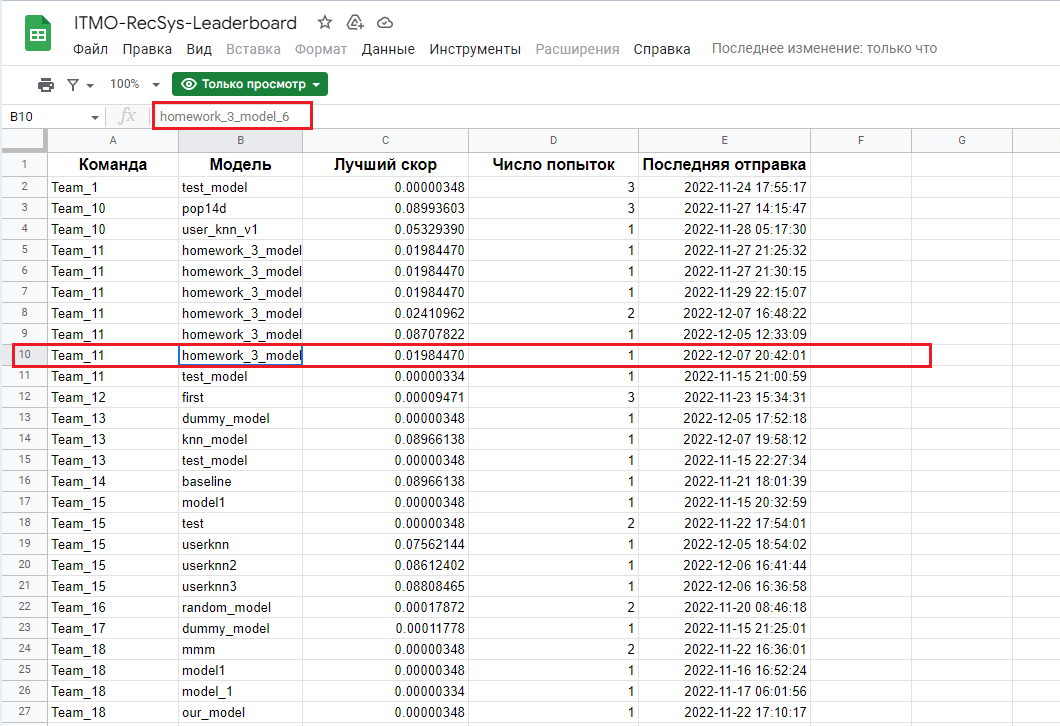